# First Solve Lagrangian Equation
This is used to determine the equations of motion for a system based on its kinetic and potential energies.

L = T - V
Where:
- L is the Lagrangian
- T is the kinetic energy
- V is the potential energy

### Import Libraries

In [2]:
from sympy import symbols, Function, diff, simplify, Eq, dsolve, solve, pprint, latex, sqrt, Matrix, det, Rational
from sympy.physics.mechanics import dynamicsymbols
from sympy import cos, sin
import numpy as np

#plotting
import matplotlib.pyplot as plt

# for displaying equations in LaTeX
from IPython.display import Math

### `solve_lagrangian(T, V, coords)`

Solve a Lagrangian mechanics problem using the Euler–Lagrange equations.

---

#### **Parameters**
| Name | Type | Description |
|------|------|-------------|
| **T** | `sympy` expression | Kinetic energy as a function of generalized coordinates and velocities. |
| **V** | `sympy` expression | Potential energy as a function of generalized coordinates. |
| **coords** | list of `dynamicsymbols` | Generalized coordinates, e.g. `[q1, q2, ...]`. |

---

#### **Returns**
| Name | Type | Description |
|------|------|-------------|
| **equations** | list of `sympy.Eq` | Euler–Lagrange equations for each coordinate. |

---

#### **Notes**
The function computes equations of motion using:
$$

\frac{d}{dt}\left( \frac{\partial \mathcal{L}}{\partial \dot{q}_i} \right)
\;-\;
\frac{\partial \mathcal{L}}{\partial q_i}
= 0

$$
where
$$  

\mathcal{L} = T - V.
$$
---


In [3]:
def solve_lagrangian_system(T, V, coords):
    """

    """
    t = symbols('t')
    
    # Define Lagrangian
    L = T - V

    L = simplify(L)
    
    print("Lagrangian L = T - V:")
    display(Math(r"L = " + latex(L)))
    
    # Compute Euler-Lagrange equations for each coordinate
    equations = []
    
    for q in coords:
        q_dot = diff(q, t)
        
        # Compute ∂L/∂q̇
        dL_dqdot = diff(L, q_dot)
        
        # Compute d/dt(∂L/∂q̇)
        d_dt_dL_dqdot = diff(dL_dqdot, t)
        
        # Compute ∂L/∂q
        dL_dq = diff(L, q)
        
        # Euler-Lagrange equation: d/dt(∂L/∂q̇) - ∂L/∂q = 0
        EL_eq = Eq(d_dt_dL_dqdot - dL_dq, 0)
        
        # Simplify the equation
        EL_eq = simplify(EL_eq)

        equations.append(EL_eq)
        pprint(f"Euler-Lagrange equation for {q}:")
        display(Math(latex((EL_eq))))
        
    
    return equations

# Code to determine Natural Frequencies and Mode Shapes
This code snippet calculates the natural frequencies and mode shapes of a system based on its mass and stiffness matrices.

In [4]:
def natural_frequencies(equations, coords):
    t = symbols('t')
    n = len(coords)

    q = Matrix(coords)
    q_dot = q.diff(t)
    q_ddot = q_dot.diff(t)

    M = Matrix.zeros(n)
    K = Matrix.zeros(n)

    # Build the mass and stiffness matrices
    for i, eq in enumerate(equations):
        expr = eq.lhs

        for j in range(n):
            M[i, j] = simplify(expr.expand().coeff(q_ddot[j]))
            K[i, j] = simplify(expr.expand().coeff(q[j]))

    # Solve det(K - λ M) = 0
    λ = symbols('lambda', real=True)
    charpoly = simplify(det(K - λ * M))
    eigenvals = solve(charpoly, λ)

    # Convert λ → ω
    omegas = [simplify(val**0.5) for val in eigenvals]

    # Mode shapes
    modes = []
    for val in eigenvals:
        A = K - val * M
        vec = A.nullspace()[0]  # one eigenvector
        modes.append(simplify(vec))

    print("Mass matrix M:")
    display(Math(r"M = " + latex(M)))
    print("Stiffness matrix K:")
    display(Math(r"K = " + latex(K)))
    print("Natural Frequencies ω:")
    for i, omega in enumerate(omegas):
        display(Math(r"\omega_{" + str(i+1) + r"} = " + latex(omega)))
    

    return M, K, omegas, modes

## Central Difference Method
This method is used for numerically solving differential equations, particularly in structural dynamics.
### `central_difference(M, K, F, u0, v0, dt, t_end)`
Perform time integration using the central difference method.
---
#### **Parameters**
| Name | Type | Description |
|------|------|-------------|
| **M** | `sympy` Matrix | Mass matrix of the system. |
| **K** | `sympy` Matrix | Stiffness matrix of the system. |
| **F** | `sympy` Matrix | External force vector as a function of time. |
| **u0** | `sympy` Matrix | Initial displacement vector. |
| **v0** | `sympy` Matrix | Initial velocity vector. |
| **dt** | `float` | Time step for integration. |
| **t_end** | `float` | End time for simulation. |
---
#### **Returns**
| Name | Type | Description |
|------|------|-------------|
| **u** | `list` of `sympy` Matrices | Displacement history over time. |
| **v** | `list` of `sympy` Matrices | Velocity history over time. |
| **a** | `list` of `sympy` Matrices | Acceleration history over time. |
---
#### **Notes**
The central difference method approximates the second derivative using finite differences, allowing for time integration of the equations of motion:
$$
M \ddot{u}(t) + K u(t) = F(t)
$$
---

In [5]:
def central_difference(M, K, F, u0, v0, dt, t_end):
    """
    Central Difference Method for M u'' + K u = F(t)
    
    Parameters
    ----------
    M : (n,n) array_like
        Mass matrix
    K : (n,n) array_like
        Stiffness matrix
    F : function
        Function of time returning force vector, F(t)
    u0 : (n,) array_like
        Initial displacement
    v0 : (n,) array_like
        Initial velocity
    dt : float
        Time step
    t_end : float
        End time

    Returns
    -------
    u : (n, num_steps) ndarray
        Displacements
    v : (n, num_steps) ndarray
        Velocities
    a : (n, num_steps) ndarray
        Accelerations
    """
    M = np.array(M, dtype=float)
    K = np.array(K, dtype=float)
    u0 = np.array(u0, dtype=float).flatten()
    v0 = np.array(v0, dtype=float).flatten()
    
    num_dof = M.shape[0]
    num_steps = int(t_end / dt) + 1
    
    # Precompute inverse mass
    M_inv = np.linalg.inv(M)
    
    # Allocate arrays
    u = np.zeros((num_dof, num_steps))
    v = np.zeros((num_dof, num_steps))
    a = np.zeros((num_dof, num_steps))
    
    # Initial conditions
    u[:, 0] = u0
    v[:, 0] = v0
    F0 = np.array(F(0), dtype=float).flatten()
    
    # Initial acceleration
    a[:, 0] = M_inv @ (F0 - K @ u0)
    
    # "Ghost step" for n = -1 (first step)
    u_minus1 = u0 - dt * v0 + 0.5 * dt**2 * (-M_inv @ (K @ u0 - F0))
    
    # Time integration
    for n in range(num_steps - 1):
        t_n1 = (n + 1) * dt
        F_n1 = np.array(F(t_n1), dtype=float).flatten()
        
        # Central difference displacement update
        u[:, n + 1] = dt**2 * M_inv @ (F_n1 - K @ u[:, n]) + 2 * u[:, n] - u_minus1
        
        # Velocity update (approximate)
        v[:, n + 1] = (u[:, n + 1] - u_minus1) / (2 * dt)
        
        # Acceleration update
        a[:, n + 1] = M_inv @ (F_n1 - K @ u[:, n + 1])
        
        # Shift ghost step
        u_minus1 = u[:, n]
    
    return u, v, a


## Houbolt Method for Time Integration
This method is used for numerically solving second-order differential equations, particularly in structural dynamics.
### `houbolt_method(M, K, F, u0, v0, dt, t_end)`
Perform time integration using the Houbolt method.
---
#### **Parameters**
| Name | Type | Description |
|------|------|-------------|
| **M** | `sympy` Matrix | Mass matrix of the system. |
| **K** | `sympy` Matrix | Stiffness matrix of the system. |
| **F** | `sympy` Matrix | External force vector as a function of time. |
| **u0** | `sympy` Matrix | Initial displacement vector. |
| **v0** | `sympy` Matrix | Initial velocity vector. |
| **dt** | `float` | Time step for integration. |
| **t_end** | `float` | End time for simulation. |
---
#### **Returns**
| Name | Type | Description |
|------|------|-------------|
| **u** | list of `sympy` Matrices | Displacement vectors at each time step. |
| **v** | list of `sympy` Matrices | Velocity vectors at each time step. |
| **a** | list of `sympy` Matrices | Acceleration vectors at each time step. |
---
#### **Notes**
The Houbolt method is an implicit time integration scheme that provides stability for solving the equations of motion:
$$

In [6]:
def houbolt(M, K, F, u0, v0, dt, t_end):
    """
    Houbolt Method for M u'' + K u = F(t)
    
    Parameters
    ----------
    M : (n,n) array_like
        Mass matrix
    K : (n,n) array_like
        Stiffness matrix
    F : function
        Function of time returning force vector, F(t)
    u0 : (n,) array_like
        Initial displacement
    v0 : (n,) array_like
        Initial velocity
    dt : float
        Time step
    t_end : float
        End time

    Returns
    -------
    u : (n, num_steps) ndarray
        Displacements
    v : (n, num_steps) ndarray
        Velocities
    a : (n, num_steps) ndarray
        Accelerations
    """
    M = np.array(M, dtype=float)
    K = np.array(K, dtype=float)
    u0 = np.array(u0, dtype=float).flatten()
    v0 = np.array(v0, dtype=float).flatten()
    
    n_dof = M.shape[0]
    n_steps = int(t_end/dt) + 1
    
    # Allocate arrays
    u = np.zeros((n_dof, n_steps))
    v = np.zeros((n_dof, n_steps))
    a = np.zeros((n_dof, n_steps))
    
    # Initial acceleration
    F0 = np.array(F(0), dtype=float).flatten()
    # Ensure M is invertible or use solve
    a0 = np.linalg.solve(M, F0 - K @ u0)
    
    # --- STEP 2 & 3: Initialization of Ghost Points ---
    # Derived via CDM (u-1) and 3-point Backward Velocity (u-2)
    u_minus1 = u0 - dt*v0 + 0.5*dt**2*a0
    u_minus2 = u0 - 2*dt*v0 + 2*dt**2*a0
    
    # Initialize first step
    u[:,0] = u0
    v[:,0] = v0
    a[:,0] = a0
    
    # --- CORRECT HOUBOLT CONSTANTS ---
    # Coefficient for Mass in effective stiffness is 2/dt^2
    alpha = 2.0 
    A = alpha * M / dt**2 + K
    A_inv = np.linalg.inv(A)
    
    # Time integration
    for n in range(n_steps-1):
        t_np1 = (n+1)*dt
        F_np1 = np.array(F(t_np1), dtype=float).flatten()
        
        # --- CORRECT HOUBOLT UPDATE FORMULA ---
        # Using coefficients 5, -4, 1 for the history terms
        rhs = F_np1 + M @ (5*u[:,n] - 4*u_minus1 + u_minus2) / dt**2
        
        u_next = A_inv @ rhs
        
        # Velocity and acceleration 
        # (Standard Houbolt / BDF3 velocity formula is correct here)
        if n >= 0: # We can actually use this immediately if ghost points are set
            a[:, n+1] = (2*u_next - 5*u[:,n] + 4*u_minus1 - u_minus2) / dt**2
            v[:, n+1] = (11*u_next - 18*u[:,n] + 9*u_minus1 - 2*u_minus2) / (6*dt)
        
        # Shift steps
        u_minus2 = u_minus1
        u_minus1 = u[:,n]
        u[:,n+1] = u_next
        
    return u, v, a

## Analytical Solution

In [7]:
def solve_analytical(M, K, omegas, modes, u0, v0, t_symbol):
    """
    Computes the analytical solution q(t) for free vibration using Mode Superposition.
    q(t) = P * (A * cos(wt) + B * sin(wt))
    
    Parameters
    ----------
    M, K : SymPy Matrix
        Mass and Stiffness matrices
    omegas : list
        List of natural frequencies (symbolic)
    modes : list
        List of mode shape vectors (symbolic)
    u0 : list/array
        Initial displacements [u1(0), u2(0), ...]
    v0 : list/array
        Initial velocities [v1(0), v2(0), ...]
    t_symbol : SymPy Symbol
        The time variable 't'
        
    Returns
    -------
    q_sol : SymPy Matrix
        The vector of functions [q1(t), q2(t), ...]
    """
    print("\n--- Analytical Solution (Free Vibration) ---")
    
    n = M.shape[0]
    
    # 1. Construct Modal Matrix P (columns are eigenvectors)
    P = Matrix.hstack(*modes)
    
    # 2. Check for convertibility (P must be invertible)
    if P.det() == 0:
        print("Error: Modal matrix is singular. Cannot decouple system analytically.")
        return None

    P_inv = P.inv()

    # 3. Transform Initial Conditions to Modal Coordinates
    # q(t) = P * eta(t)  =>  eta(t) = P_inv * q(t)
    
    q0_vec = Matrix(u0)
    dq0_vec = Matrix(v0)
    
    # Initial modal displacement: eta(0) = P^-1 * q(0)
    eta0 = P_inv * q0_vec
    
    # Initial modal velocity: d_eta(0) = P^-1 * dq(0)
    deta0 = P_inv * dq0_vec
    
    # 4. Solve for Modal Coordinates eta_i(t)
    # Equation: d^2(eta)/dt^2 + w^2 * eta = 0
    # Solution: eta(t) = C1*cos(wt) + C2*sin(wt)
    # Using ICs: eta(t) = eta(0)*cos(wt) + (d_eta(0)/w)*sin(wt)
    
    eta_solutions = []
    
    for i in range(n):
        omega = omegas[i]
        
        if omega == 0:
            # Rigid body mode solution: eta(t) = eta(0) + d_eta(0)*t
            sol = eta0[i] + deta0[i] * t_symbol
        else:
            # Oscillatory solution
            sol = eta0[i] * cos(omega * t_symbol) + (deta0[i] / omega) * sin(omega * t_symbol)
            
        eta_solutions.append(sol)
    
    eta_vec = Matrix(eta_solutions)
    
    # 5. Transform back to Physical Coordinates
    # q(t) = P * eta(t)
    q_sol = P * eta_vec
    q_sol = simplify(q_sol)
    
    for i in range(n):
        display(Math(f"q_{i+1}(t) = " + latex(q_sol[i])))
        
    return q_sol

## Example of a double pendulum solving

### Define Symbols and Variables

In [8]:
# Parameters
t = symbols('t')
m1, m2 = symbols('m1 m2', positive=True, real=True)  # masses
L1, L2 = symbols('L1 L2', positive=True, real=True)  # lengths
g = symbols('g', positive=True, real=True)  # gravity

# Generalized coordinates (angles from vertical)
theta1 = dynamicsymbols('theta1')
theta2 = dynamicsymbols('theta2')

theta1_dot = diff(theta1, t)
theta2_dot = diff(theta2, t)

# Position of mass 1
x1 = L1 * sin(theta1)
y1 = -L1 * cos(theta1)

# Position of mass 2
x2 = L1 * sin(theta1) + L2 * sin(theta2)
y2 = -L1 * cos(theta1) - L2 * cos(theta2)

# Velocities
x1_dot = diff(x1, t)
y1_dot = diff(y1, t)
x2_dot = diff(x2, t)
y2_dot = diff(y2, t)

### Define the Kinetic and Potential Energies

In [9]:
# Kinetic energy: T = (1/2)*m1*v1^2 + (1/2)*m2*v2^2
T_double = Rational(1,2) * m1 * (x1_dot**2 + y1_dot**2) + Rational(1,2) * m2 * (x2_dot**2 + y2_dot**2)
T_double = simplify(T_double)

# Potential energy: V = m1*g*y1 + m2*g*y2
V_double = m1 * g * y1 + m2 * g * y2
V_double = simplify(V_double)

### Solve the Lagrangian Equations

In [10]:
equations_double = solve_lagrangian_system(T_double, V_double, [theta1, theta2])

Lagrangian L = T - V:


<IPython.core.display.Math object>

Euler-Lagrange equation for theta1(t):


<IPython.core.display.Math object>

Euler-Lagrange equation for theta2(t):


<IPython.core.display.Math object>

## Example of a two cart spring system fixed at both ends
### Define Symbols and Variables

In [11]:
# Parameters
t = symbols('t')
m1, m2 = symbols('m1 m2', positive=True, real=True)  # masses
k1, k2, k3 = symbols('k1 k2 k3', positive=True, real=True)  # spring constants

# Generalized coordinates (displacements from equilibrium)
x1 = dynamicsymbols('x1')
x2 = dynamicsymbols('x2')

# Velocities
x1_dot = diff(x1, t)
x2_dot = diff(x2, t)

### Define the Kinetic and Potential Energies

In [12]:
# Kinetic energy: T = 1/2*m1*x1_dot^2 + 1/2*m2*x2_dot^2
T_double = Rational(1,2) * m1 * x1_dot**2 + Rational(1,2) * m2 * x2_dot**2
T_double = simplify(T_double)

# Potential energy: V = 1/2*k1*x1^2 + 1/2*k2*(x2 - x1)^2 + 1/2*k3*x2^2 
V_double = Rational(1,2) * k1 * x1**2 + Rational(1,2) * k2 * (x2 - x1)**2 + Rational(1,2) * k3 * x2**2
V_double = simplify(V_double)

### Solve the Lagrangian Equations

In [13]:
equations_double = solve_lagrangian_system(T_double, V_double, [x1, x2])
M, K, omegas, modes = natural_frequencies(equations_double, [x1, x2])

Lagrangian L = T - V:


<IPython.core.display.Math object>

Euler-Lagrange equation for x1(t):


<IPython.core.display.Math object>

Euler-Lagrange equation for x2(t):


<IPython.core.display.Math object>

Mass matrix M:


<IPython.core.display.Math object>

Stiffness matrix K:


<IPython.core.display.Math object>

Natural Frequencies ω:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Example Quiz 7
### Define Symbols and Variables

In [14]:
# Parameters
t = symbols('t')
m1, m2 = 1,1  # masses
k1, k2 = 10,10  # spring constants
r = 1  # radius 

I = Rational(1,2) * m1 * r**2  # moment of inertia of disk

# Generalized coordinates (displacements from equilibrium)
theta = dynamicsymbols('theta')
x = dynamicsymbols('x')

# Velocities
theta_dot = diff(theta, t)
x_dot = diff(x, t)

### Define the Kinetic and Potential Energies

In [15]:
T = Rational(1,2) * m2 * x_dot**2 + Rational(1,2) * I * theta_dot**2
T = simplify(T)

V = Rational(1,2) * k1 * (theta * r)**2 + Rational(1,2) * k2 * (x-theta*r)**2
V = simplify(V)

### Solve the Lagrangian Equations

In [16]:
eq_system = solve_lagrangian_system(T, V, [theta, x])

Lagrangian L = T - V:


<IPython.core.display.Math object>

Euler-Lagrange equation for theta(t):


<IPython.core.display.Math object>

Euler-Lagrange equation for x(t):


<IPython.core.display.Math object>

In [17]:
M, K, omegas, modes = natural_frequencies(eq_system, [theta, x])

Mass matrix M:


<IPython.core.display.Math object>

Stiffness matrix K:


<IPython.core.display.Math object>

Natural Frequencies ω:


<IPython.core.display.Math object>

<IPython.core.display.Math object>


--- Analytical Solution (Free Vibration) ---


<IPython.core.display.Math object>

<IPython.core.display.Math object>

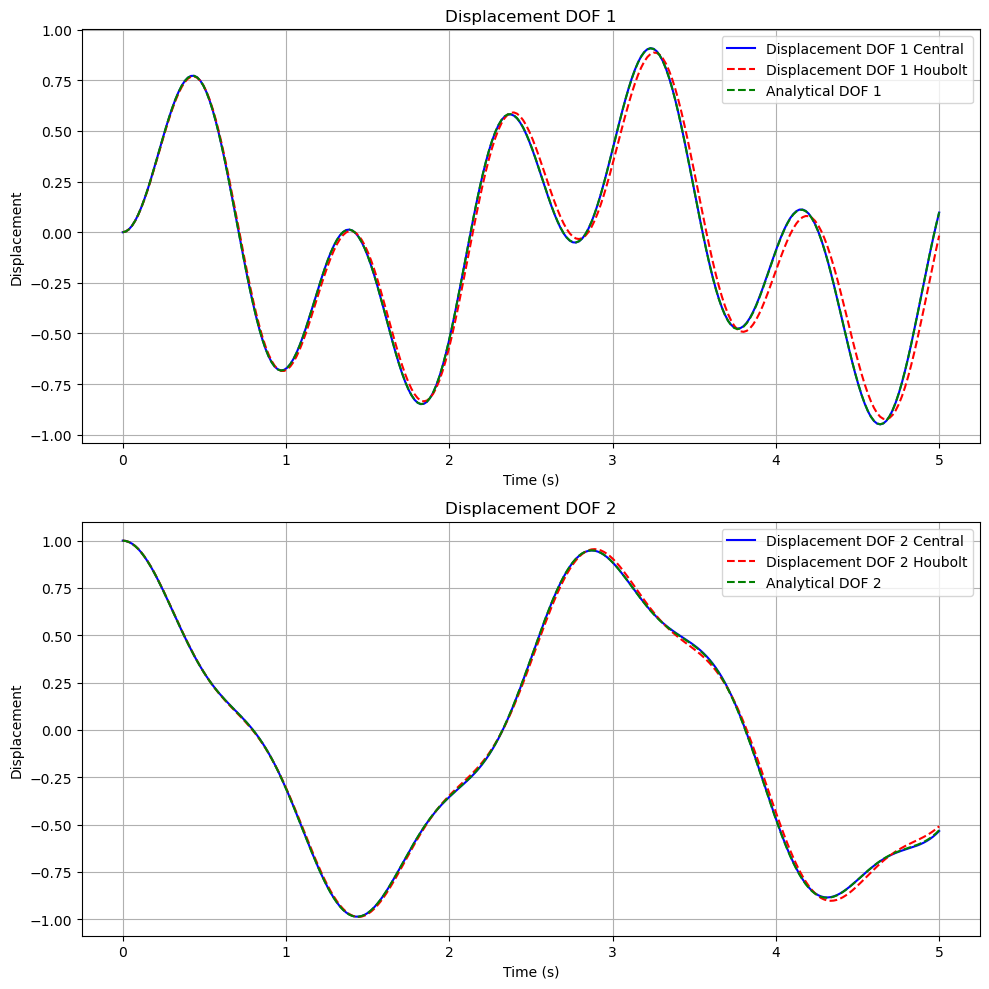

Central Difference Displacement DOF 1 (first 10 values): [0.         0.00361    0.01437484 0.03210012 0.05646543 0.08702967
 0.12323838 0.16443294 0.20986155 0.25869166]
Houbolt Displacement DOF 1 (first 10 values): [0.         0.00357769 0.01423064 0.03174419 0.05579309 0.08594095
 0.12164445 0.16226086 0.20705777 0.25522484]


In [ ]:
q_sol = solve_analytical(M, K, omegas, modes, [0, 1], [0, 0], t)

dt = 0.019
t_end = 5.0
num_steps = int(t_end / dt) + 1
t_vals = np.linspace(0, t_end, num_steps)

u_central, v_central, a_central = central_difference(M, K, lambda t: np.array([0, 0]), [0, 1], [0, 0], dt, t_end)
u_houbolt, v_houbolt, a_houbolt = houbolt(M, K, lambda t: np.array([0, 0]), [0, 1], [0, 0], dt, t_end)

plt.figure(figsize=(10,10))

# DOF 1
plt.subplot(2, 1, 1)
plt.plot(t_vals, u_central[0, :], label='Displacement DOF 1 Central', color='blue')
plt.plot(t_vals, u_houbolt[0, :], label='Displacement DOF 1 Houbolt', linestyle='--', color='red')
# Analytical solution for DOF 1
q1_analytical = [float(q_sol[0].subs({t: tv})) for tv in t_vals]
plt.plot(t_vals, q1_analytical, label='Analytical DOF 1', linestyle='--', color='green')
plt.title('Displacement DOF 1')
plt.xlabel('Time (s)')
plt.ylabel('Displacement')
plt.legend()
plt.grid()

# DOF 2
plt.subplot(2, 1, 2)
plt.plot(t_vals, u_central[1, :], label='Displacement DOF 2 Central', color='blue')
plt.plot(t_vals, u_houbolt[1, :], label='Displacement DOF 2 Houbolt', linestyle='--', color='red')
# Analytical solution for DOF 2
q2_analytical = [float(q_sol[1].subs({t: tv})) for tv in t_vals]
plt.plot(t_vals, q2_analytical, label='Analytical DOF 2', linestyle='--', color='green')

plt.title('Displacement DOF 2')
plt.xlabel('Time (s)')
plt.ylabel('Displacement')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# print the heads of the displacement arrays for comparison
print("Central Difference Displacement DOF 1 (first 10 values):", u_central[0, :10])
print("Houbolt Displacement DOF 1 (first 10 values):", u_houbolt[0, :10])   
